In [113]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState

In [2]:
#generate a random tensor list
qubit_num = 10
bond_dim = 50
tensor_liste = [pt.randn([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [114]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [157]:
ratio_h_j = 0.1
qubit_num = 6
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)

In [158]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-5.020016662087988


In [5]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 10
num_of_measurements = np.array([10, 20, 50, 100, 200, 500])
num_of_measurements_per_rot = 50
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
for b in range(batches):
    print('starting batch ' + str(b))
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            #probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
            # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
            # thus we compute the probabilities again, from the tensors directly
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
        energy = pt.mean(energies)
        energies_different_meas_num[i,b] = energy

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9


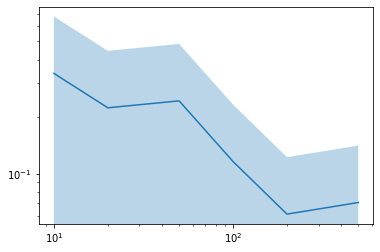

In [6]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')

In [216]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 6
ratio_h_j = 0.1
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [27]:
# we estimate the energy exactly by contraction with the hamiltonian
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
mps.from_param_vec(param_vec=random_param_vec_brute)
psi = mps.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
print(f'BF E = {energy_bf}')
energy_bf.backward()

BF E = (0.600634124889247+2.5211187699186517e-18j)


In [12]:
# now we estimate the gradient by using the classical shadows
num_of_measurements = np.array([10, 20, 50, 100, 200])
num_of_measurements_per_rot = 40
batches = 5
errors = np.zeros((np.size(num_of_measurements), batches))

for b in range(0, batches):
    for j in range(np.size(num_of_measurements)):
        random_param_vec_shadow = random_param_vec.detach()
        random_param_vec_shadow.requires_grad_(True)
        mps = MPS.from_tensor_list(tensor_liste_rand)
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
    #mps.tensors[0] = mps.tensors[0] / mps.norm()
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[j], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            # first get the unique elements of this torch tensor
            unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
            # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
            # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
            # thus we compute the probabilities again, from the tensors directly
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
        energy_shadow = pt.mean(energies)
        print(f'SH E = {energy_shadow}')
        energy_shadow.backward()
        errors[j,b] = pt.linalg.norm((random_param_vec_brute.grad - random_param_vec_shadow.grad)/pt.linalg.norm(random_param_vec_brute.grad))

SH E = 0.8326031565666199
SH E = 0.8806241154670715
SH E = 0.44312527775764465
SH E = 0.6148746013641357
SH E = 0.5727687478065491
SH E = 0.7059080004692078
SH E = 0.49469080567359924
SH E = 0.6866909861564636
SH E = 0.6350687742233276
SH E = 0.5702512860298157
SH E = 0.5326325297355652
SH E = 0.47048258781433105
SH E = 0.6034673452377319
SH E = 0.662465512752533
SH E = 0.6427615284919739
SH E = 0.46007734537124634
SH E = 0.9036332964897156
SH E = 0.5854982137680054
SH E = 0.6172842979431152
SH E = 0.506797730922699
SH E = 0.67280113697052
SH E = 0.6095503568649292
SH E = 0.655240535736084
SH E = 0.5831606388092041
SH E = 0.6744564771652222


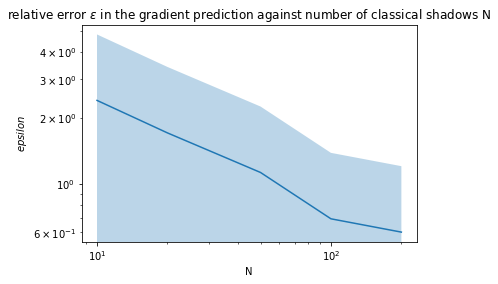

In [15]:
rel_error_mean = np.mean(errors, axis=1)
rel_error_std = np.mean(errors, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.title('relative error $\epsilon$ in the gradient prediction against number of classical shadows N')
plt.xlabel('N')
plt.ylabel('$epsilon$')
plt.yscale('log')
plt.xscale('log')

In [ ]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state

In [9]:
# doing gradient descent using pytorch optimizer
step_num = 500
lr = 0.01
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()

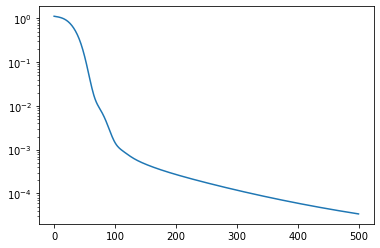

In [10]:
plt.plot(np.arange(0, step_num), accuracy)
plt.yscale('log')

In [31]:
# doing gradient descent using pytorch optimizer
step_num = 100
lr = 0.01
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
num_of_measurements = 100
num_of_measurements_per_rot = 100 #this has to be high enough, if there is only one unique measurement outcome aleksei's amplitude method fails

accuracy = np.zeros(step_num)
for i in range(step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec=random_param_vec_shadow)
    mps.normalise()
    with pt.no_grad():
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot)
    energies = pt.zeros(len(meas_outcomes))
    for n in range(len(meas_outcomes)):
        # first get the unique elements of this torch tensor
        unique_meas_outcomes, index_perm = np.unique(meas_outcomes[n].numpy(), return_index=True)
        # probs_sorted = probs[n][index_perm] # if we just want to compute the energy we can easily use these probabilities we get for free when sampling
        # when we want to determine the gradient via autodiff though, the connection to the underlying tensors has to be more direct
        # thus we compute the probabilities again, from the tensors directly
        probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(unique_meas_outcomes))
        measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(unique_meas_outcomes), unique_meas_outcomes, qubit_num)
        energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
    energy_shadow = pt.mean(energies)
    energy_shadow.backward()
    accuracy[i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 0 / 100
progress: 1 / 100
progress: 2 / 100
progress: 3 / 100
progress: 4 / 100
progress: 5 / 100
progress: 6 / 100
progress: 7 / 100
progress: 8 / 100
progress: 9 / 100
progress: 10 / 100
progress: 11 / 100
progress: 12 / 100
progress: 13 / 100
progress: 14 / 100
progress: 15 / 100
progress: 16 / 100
progress: 17 / 100
progress: 18 / 100
progress: 19 / 100
progress: 20 / 100
progress: 21 / 100
progress: 22 / 100
progress: 23 / 100
progress: 24 / 100
progress: 25 / 100
progress: 26 / 100
progress: 27 / 100
progress: 28 / 100
progress: 29 / 100
progress: 30 / 100
progress: 31 / 100
progress: 32 / 100
progress: 33 / 100
progress: 34 / 100
progress: 35 / 100
progress: 36 / 100
progress: 37 / 100
progress: 38 / 100
progress: 39 / 100
progress: 40 / 100
progress: 41 / 100
progress: 42 / 100
progress: 43 / 100
progress: 44 / 100
progress: 45 / 100
progress: 46 / 100
progress: 47 / 100
progress: 48 / 100
progress: 49 / 100
progress: 50 / 100
progress: 51 / 100
progress: 52 / 100
pro

Text(0, 0.5, '$\\epsilon$')

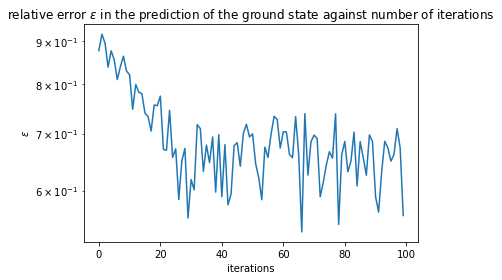

In [36]:
plt.plot(np.arange(0, step_num), accuracy)
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')

In [22]:
%timeit MPSQuantumState(qubit_num, mps).amplitude(pt.tensor([0]))

3 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
mps.normalise()
mps.canonicalise(qubit_num -1)

In [24]:
%timeit MPSQuantumState(qubit_num, mps).measure()

10.8 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit mps.amplitude(pt.tensor([0, 2]))

528 µs ± 36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
print(mps.tensors)

[tensor([[[ 0.7071+0.0000e+00j,  0.0000+0.0000e+00j],
         [-0.0706+2.0131e-14j, -0.7036+0.0000e+00j]]], dtype=torch.complex128), tensor([[[-5.5857e-02+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j],
         [ 4.5101e-01+2.6037e-13j,  8.9042e-01+1.2722e-13j,
           2.4906e-02+0.0000e+00j,  0.0000e+00+0.0000e+00j]],

        [[-8.9300e-01+2.5713e-13j,  4.4659e-01+4.5919e-30j,
           0.0000e+00+0.0000e+00j,  0.0000e+00-0.0000e+00j],
         [-2.8554e-04-9.6821e-15j, -5.5839e-02+1.2964e-14j,
          -1.2462e-03+3.0677e-16j,  6.2323e-04-5.1267e-34j]]],
       dtype=torch.complex128), tensor([[[-4.4845e-01+0.0000e+00j,  0.0000e+00-0.0000e+00j,
           0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
           0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
           0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j],
         [ 6.8031e-02-2.6044e-12j,  8.9093e-01-1.3052e-15j,
           4.1871e-03-1.0826e-12j, -2.1982e-0

In [38]:
pt.multinomial(pt.tensor([0.8, 0.2]), 100, replacement=True)

tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [63]:
m = pt.distributions.binomial.Binomial(100, pt.tensor([0.8]))
x = m.sample()
print(x)

tensor([79.])


In [106]:
num_samples_tensor = pt.tensor([100])
sampled_visibles = [pt.tensor([])]
probs_sampled = pt.tensor([1])

In [111]:

for hist in range(len(sampled_visibles)):
    result = pt.tensor([[0., 0.5], [0.5, 0.005]])
    if hist==0:
        result_zero = pt.abs(pt.tensor([result[0,0].item()]))
        result_one = pt.abs(pt.tensor([result[1,1].item()]))
    else:
        result_zero = pt.cat((result_zero, pt.abs(pt.tensor([result[0,0].item()]))))
        result_one = pt.cat((result_one, pt.abs(pt.tensor([result[0,0].item()]))))
probs_in_zero = result_zero / probs_sampled
distrib = pt.distributions.binomial.Binomial(num_samples_tensor, probs_in_zero)
num_zeros = distrib.sample()
print(num_zeros)

ValueError: Expected parameter probs (Tensor of shape (4,)) of distribution Binomial(total_count: torch.Size([4]), probs: torch.Size([4])) to satisfy the constraint Interval(lower_bound=0.0, upper_bound=1.0), but found invalid values:
tensor([0.5000, 0.5000, 2.5000, 0.5000])

In [110]:
num_ones = num_samples_tensor - num_zeros
num_samples_tensor = pt.cat((num_zeros, num_ones))
sampled_visible_update = []
for j in range(0, len(sampled_visibles)):
    if num_samples_tensor[j] > 0:
        sampled_visible_update.append(pt.cat((sampled_visibles[j], pt.tensor([0]))))
for j in range(0, len(sampled_visibles)):
    if num_samples_tensor[j + len(sampled_visibles)] > 0:
        sampled_visible_update.append(pt.cat((sampled_visibles[j], pt.tensor([1]))))
sampled_visibles = sampled_visible_update
probs_sampled = pt.cat((result_zero, result_one))
print(num_samples_tensor)
print(sampled_visibles)
print(probs_sampled)
non_zeros = pt.nonzero(num_samples_tensor, as_tuple=True)
num_samples_tensor = num_samples_tensor[non_zeros]
probs_sampled = probs_sampled[non_zeros]

tensor([ 8.,  6., 75., 11.])
[tensor([0., 0.]), tensor([1., 0.]), tensor([0., 1.]), tensor([1., 1.])]
tensor([0.1000, 0.1000, 0.0200, 0.1000])


In [91]:
print(num_samples_tensor)
print(sampled_visibles)
print(probs_sampled)

tensor([ 1., 80., 19.])
[tensor([0., 0.]), tensor([0., 1.]), tensor([1., 1.])]
tensor([0.0100, 0.2000, 0.0100])


In [203]:
def sampling(qubit_num, tensor_list, num_samples):
    num_samples_tensor = pt.tensor([num_samples])
    sampled_visibles = [pt.tensor([])]
    probs_sampled = pt.tensor([1])
    contraction_results = []
    for idx_rev in range(qubit_num - 1, -1, -1):
        contr_res_intermed = []
        for hist in range(len(sampled_visibles)):
            if idx_rev == qubit_num - 1:
                result = tensor_list[idx_rev]
            else:
                result = contraction_results[hist]
                #Top -> Bottom
                result = pt.einsum('ij,kj->ik', result, tensor_list[idx_rev + 1][:, int(sampled_visibles[hist][(qubit_num - 1) - (idx_rev + 1)]), :].conj())
                #Left -> Right
                result = pt.einsum('ik,jai->jak', result, tensor_list[idx_rev])
            contr_res_intermed.append(result)
            prob_result = pt.einsum('iaj,ibj->ab', result, tensor_list[idx_rev].conj())
            if hist==0:
                result_zero = pt.abs(pt.tensor([prob_result[0,0].item()]))
                result_one = pt.abs(pt.tensor([prob_result[1,1].item()]))
            else:
                result_zero = pt.cat((result_zero, pt.abs(pt.tensor([prob_result[0,0].item()]))))
                result_one = pt.cat((result_one, pt.abs(pt.tensor([prob_result[1,1].item()]))))

        probs_in_zero = result_zero / probs_sampled
        distrib = pt.distributions.binomial.Binomial(num_samples_tensor, probs_in_zero)
        num_zeros = distrib.sample()
        num_ones = num_samples_tensor - num_zeros
        num_samples_tensor = pt.cat((num_zeros, num_ones))
        sampled_visible_update = []
        contraction_results = []
        for j in range(0, len(sampled_visibles)):
            if num_samples_tensor[j] > 0:
                sampled_visible_update.append(pt.cat((sampled_visibles[j], pt.tensor([0]))))
                contraction_results.append(contr_res_intermed[j][:,0,:])
        for j in range(0, len(sampled_visibles)):
            if num_samples_tensor[j + len(sampled_visibles)] > 0:
                sampled_visible_update.append(pt.cat((sampled_visibles[j], pt.tensor([1]))))
                contraction_results.append(contr_res_intermed[j][:,1,:])
        sampled_visibles = sampled_visible_update
        probs_sampled = pt.cat((result_zero, result_one))
        non_zeros = pt.nonzero(num_samples_tensor, as_tuple=True)
        num_samples_tensor = num_samples_tensor[non_zeros]
        probs_sampled = probs_sampled[non_zeros]
    return num_samples_tensor, sampled_visibles, probs_sampled

In [218]:
mps.canonicalise(qubit_num - 1)
mps.normalise()

In [219]:
%timeit sampling(qubit_num, mps.tensors, 100)

28.7 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [211]:
%timeit MPSQuantumState(qubit_num, mps).measure()

1.13 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
